In [1]:
import os
import urllib

# Download the data
API_KEY = "PO6RG0NM9390YF3A"
STOCK_SYMBOL = "SPY"
INTERVAL = "1min"
DATA_TYPE = "WEEKLY" # INTRADAY || DAILY || WEEKLY || MONTHLY

if DATA_TYPE == "intraday":
    DOWNLOAD_ROOT = f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={STOCK_SYMBOL}&interval={INTERVAL}&apikey={API_KEY}&datatype=csv&ouputsize=full"
else:
    DOWNLOAD_ROOT = f"https://www.alphavantage.co/query?function=TIME_SERIES_{DATA_TYPE}&symbol={STOCK_SYMBOL}&apikey={API_KEY}&datatype=csv&ouputsize=full"
filename = STOCK_SYMBOL+"_"+DATA_TYPE+".csv"
datapath = "rawdata/"
os.makedirs(datapath, exist_ok=True)
urllib.request.urlretrieve(DOWNLOAD_ROOT, datapath+filename)
print('Download complete.')

Download complete.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

stock_data = pd.read_csv(datapath + filename, thousands=',')

stock_data = stock_data.iloc[::-1]
print(stock_data)

       timestamp      open      high       low     close     volume
1042  2000-05-19  142.7500  147.7187  140.4062  141.1250   29384700
1041  2000-05-26  141.2500  141.8125  136.5000  138.0000   42993000
1040  2000-06-02  140.0000  149.0937  139.4687  147.8437   29343000
1039  2000-06-09  147.4687  148.2187  145.6250  146.5937   25584900
1038  2000-06-16  146.9687  148.8750  144.6250  146.5937   28107200
...          ...       ...       ...       ...       ...        ...
4     2020-04-09  257.8400  281.2000  248.1698  278.2000  728498717
3     2020-04-17  277.1400  287.3000  271.4100  286.6400  641620261
2     2020-04-24  282.6100  286.7912  272.0200  282.9700  506655211
1     2020-05-01  285.1200  294.8800  281.5200  282.7900  546963684
0     2020-05-08  280.7400  292.9500  279.1300  292.4400  374854032

[1043 rows x 6 columns]


In [3]:
label = []
for index, row in stock_data.iterrows():
    if row['close'] > row['open']:
        label.append('buy')
    else:
        label.append('sell')
stock_data['action'] = label
print(stock_data)

       timestamp      open      high       low     close     volume action
1042  2000-05-19  142.7500  147.7187  140.4062  141.1250   29384700   sell
1041  2000-05-26  141.2500  141.8125  136.5000  138.0000   42993000   sell
1040  2000-06-02  140.0000  149.0937  139.4687  147.8437   29343000    buy
1039  2000-06-09  147.4687  148.2187  145.6250  146.5937   25584900   sell
1038  2000-06-16  146.9687  148.8750  144.6250  146.5937   28107200   sell
...          ...       ...       ...       ...       ...        ...    ...
4     2020-04-09  257.8400  281.2000  248.1698  278.2000  728498717    buy
3     2020-04-17  277.1400  287.3000  271.4100  286.6400  641620261    buy
2     2020-04-24  282.6100  286.7912  272.0200  282.9700  506655211    buy
1     2020-05-01  285.1200  294.8800  281.5200  282.7900  546963684   sell
0     2020-05-08  280.7400  292.9500  279.1300  292.4400  374854032    buy

[1043 rows x 7 columns]


In [4]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [5]:
from matplotlib import cm

X = stock_data[['open','high','low','close','volume']]
y = stock_data['action']
#training set = 70% of dataset(seems to give best accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=0)

In [7]:
tree_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

In [9]:
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[134  18]
 [126  35]]


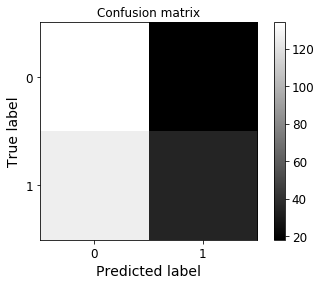

In [10]:
confusion_mat = confusion_matrix(y_test, y_pred)

print(confusion_mat)

plot_confusion_matrix(confusion_mat, 2)

In [18]:
from sklearn.model_selection import KFold 
# k= 10
kf = KFold(n_splits=10, random_state=None, shuffle=True)

kf.get_n_splits(X)

print(kf)

KFold(n_splits=10, random_state=None, shuffle=True)


In [20]:
from sklearn.model_selection import cross_val_score
#Entropy
tree_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=0)
for train_index, test_index in kf.split(X):

    tree_clf.fit(X_train, y_train)
    
    y_pred = tree_clf.predict(X_test)
    
    target_names = ['buy','sell']
    print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         buy       0.52      0.88      0.65       152
        sell       0.66      0.22      0.33       161

    accuracy                           0.54       313
   macro avg       0.59      0.55      0.49       313
weighted avg       0.59      0.54      0.48       313

              precision    recall  f1-score   support

         buy       0.52      0.88      0.65       152
        sell       0.66      0.22      0.33       161

    accuracy                           0.54       313
   macro avg       0.59      0.55      0.49       313
weighted avg       0.59      0.54      0.48       313

              precision    recall  f1-score   support

         buy       0.52      0.88      0.65       152
        sell       0.66      0.22      0.33       161

    accuracy                           0.54       313
   macro avg       0.59      0.55      0.49       313
weighted avg       0.59      0.54      0.48       313

              preci